# **Climate Change Analysis Using Satellite Imagery: Temperature Time-Series and Forecasting**

### **Project Objective:**  
Forecast temperature changes across ***Africa, South America, Europe and Asia***.

---




#**1. Data Loading and Preprocessing**


### **Import the needed Libraries**



In [ ]:
import ee
import tempfile
import zipfile
import requests
from osgeo import gdal
import numpy as np

import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv1D, Dense, Input, BatchNormalization, Activation, Add, SpatialDropout1D, Flatten, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

## **Load Images**

In [ ]:
ee.Authenticate()
ee.Initialize(project='deeplearning1234')

collection = ee.ImageCollection('ECMWF/ERA5/DAILY').limit(10)
collection_size = collection.size().getInfo()
print(f"Number of images in the collection: {collection_size}")

export_scale = 30000

def download_image_to_array(image, region, index):
    try:
        url = image.clip(region).getDownloadURL({'scale': export_scale, 'region': region})
        with tempfile.NamedTemporaryFile(suffix=".zip") as tmp_zip:
            response = requests.get(url, stream=True)
            if response.status_code != 200:
                print(f"Failed to download image {index}")
                return None

            tmp_zip.write(response.content)
            tmp_zip.flush()

            with zipfile.ZipFile(tmp_zip.name, 'r') as z:
                tiff_files = [n for n in z.namelist() if n.lower().endswith('.tif')]
                if not tiff_files:
                    return None
                with tempfile.NamedTemporaryFile(suffix=".tif") as tmp_tiff:
                    tmp_tiff.write(z.read(tiff_files[0]))
                    tmp_tiff.flush()

                    dataset = gdal.Open(tmp_tiff.name)
                    if not dataset:
                        return None
                    return dataset.GetRasterBand(1).ReadAsArray()
    except Exception as e:
        print(f"Error processing image {index}: {e}")
        return None

images_list = collection.toList(collection_size)

Number of images in the collection: 10


In [ ]:
def download_images_for_region(region, region_name, display=10):
    region_arrays = [
        download_image_to_array(ee.Image(images_list.get(i)), region, i)
        for i in range(collection_size)
    ]

    region_arrays = [a for a in region_arrays if a is not None]

    region_numpy = np.stack(region_arrays)
    print(f"{region_name} - Final numpy array shape:", region_numpy.shape)

    plt.figure(figsize=(13, 8))
    num_images = min(region_numpy.shape[0], display)
    for i in range(num_images):
        plt.subplot(int(np.ceil(num_images / 5)), 5, i + 1)
        plt.imshow(region_numpy[i], cmap='inferno')
        plt.title(f"{region_name} Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**We started by defining the geographical boundaries using polygons, for 4 continents :**


*   Africa
*   South America
*   Asia
* Europe






In [ ]:
africa = ee.Geometry.Polygon([
    [[-18.0, 38.0],
     [-18.0, -35.0],
     [51.0, -35.0],
     [51.0, 38.0],
     [-18.0, 38.0]]
])


south_america = ee.Geometry.Polygon([
    [[-81.0, 12.0],
     [-81.0, -55.0],
     [-34.0, -55.0],
     [-34.0, 12.0],
     [-81.0, 12.0]]
])


europe = ee.Geometry.Polygon([
  [[-25.0, 81.0],
    [-25.0, 34.0],
    [60.0, 34.0],
    [60.0, 81.0],
    [-25.0, 81.0]
  ]
])


asia = ee.Geometry.Polygon([
    [[25.0, 81.0],
     [25.0, 5.0],
     [180.0, 5.0],
     [180.0, 81.0],
     [25.0, 81.0]]
])



> **After fetching the satellite images from the Earth Engine collection, we converted each image into np array**


> **Then, visualized them**



Europe - Final numpy array shape: (10, 184, 316)


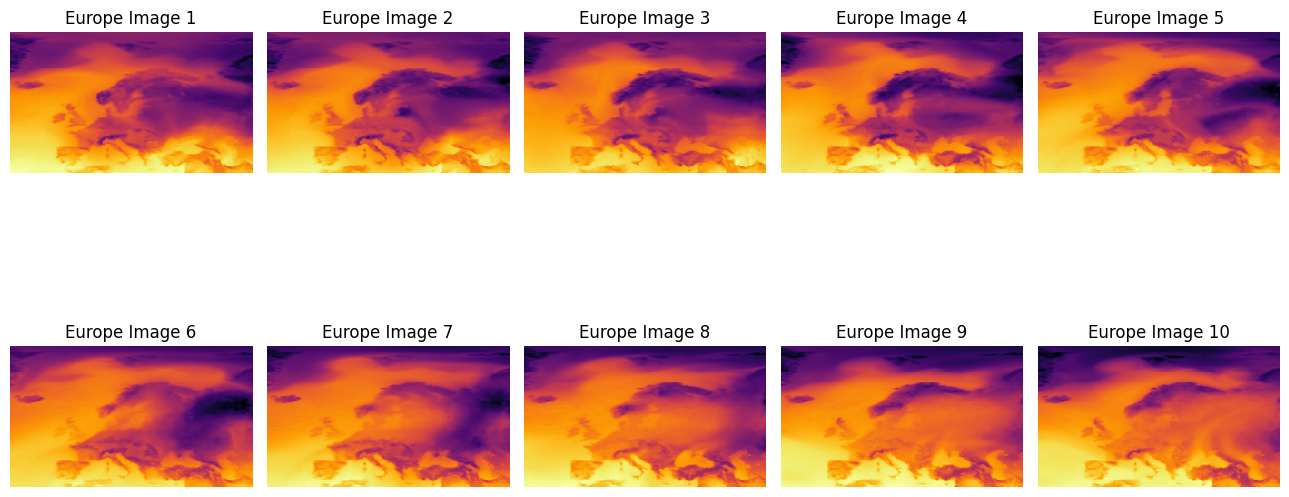

In [ ]:
download_images_for_region(europe, "Europe")

Asia - Final numpy array shape: (10, 309, 576)


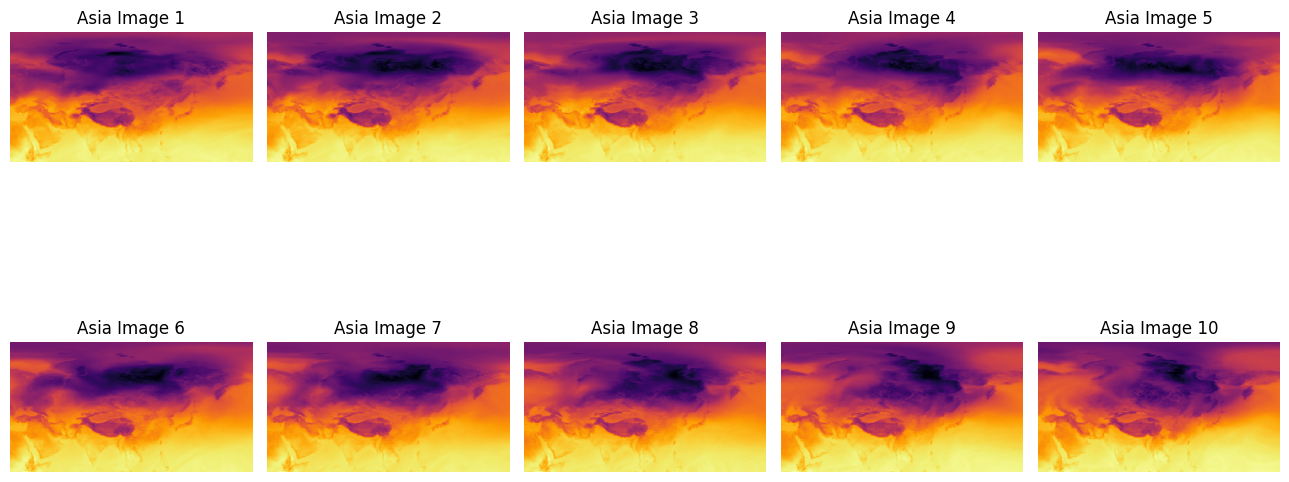

In [ ]:
download_images_for_region(asia, "Asia")

Error processing image 9: Caller does not have required permission to use project deeplearning1234. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=deeplearning1234 and then retry. Propagation of the new permission may take a few minutes.
Africa - Final numpy array shape: (9, 312, 257)


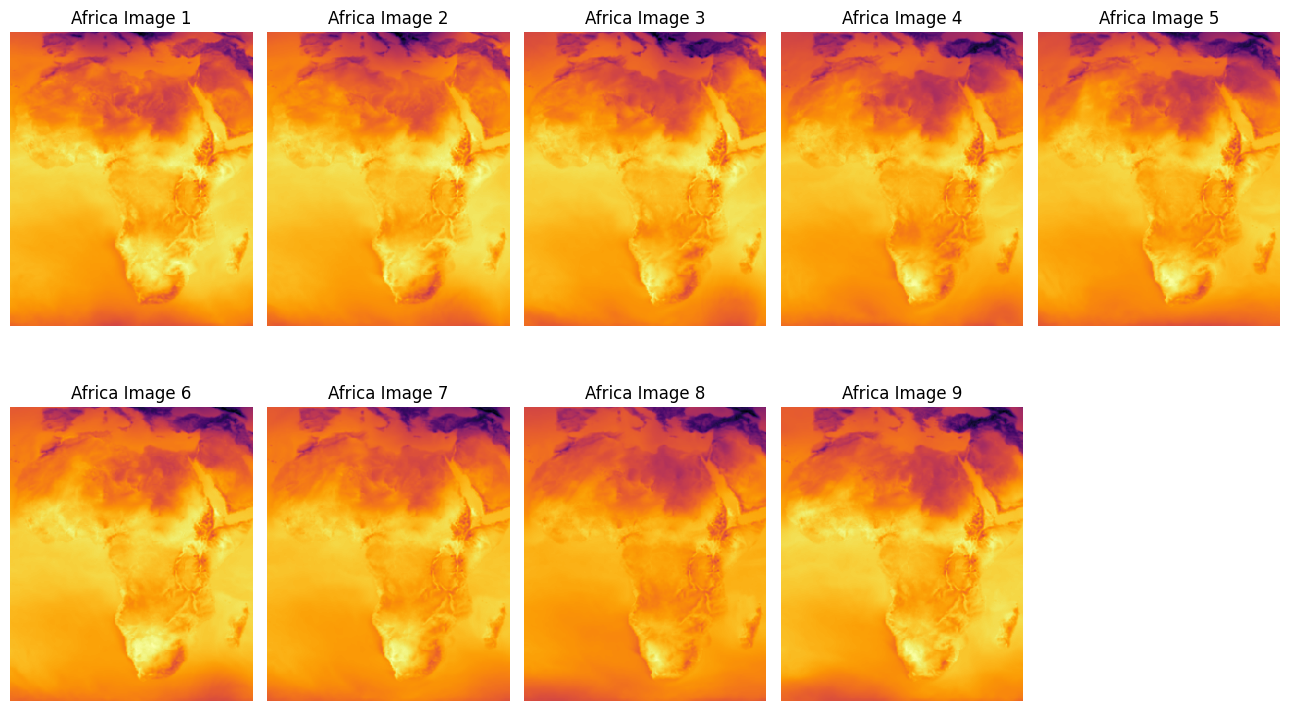

In [ ]:
download_images_for_region(africa, "Africa")

South America - Final numpy array shape: (10, 262, 175)


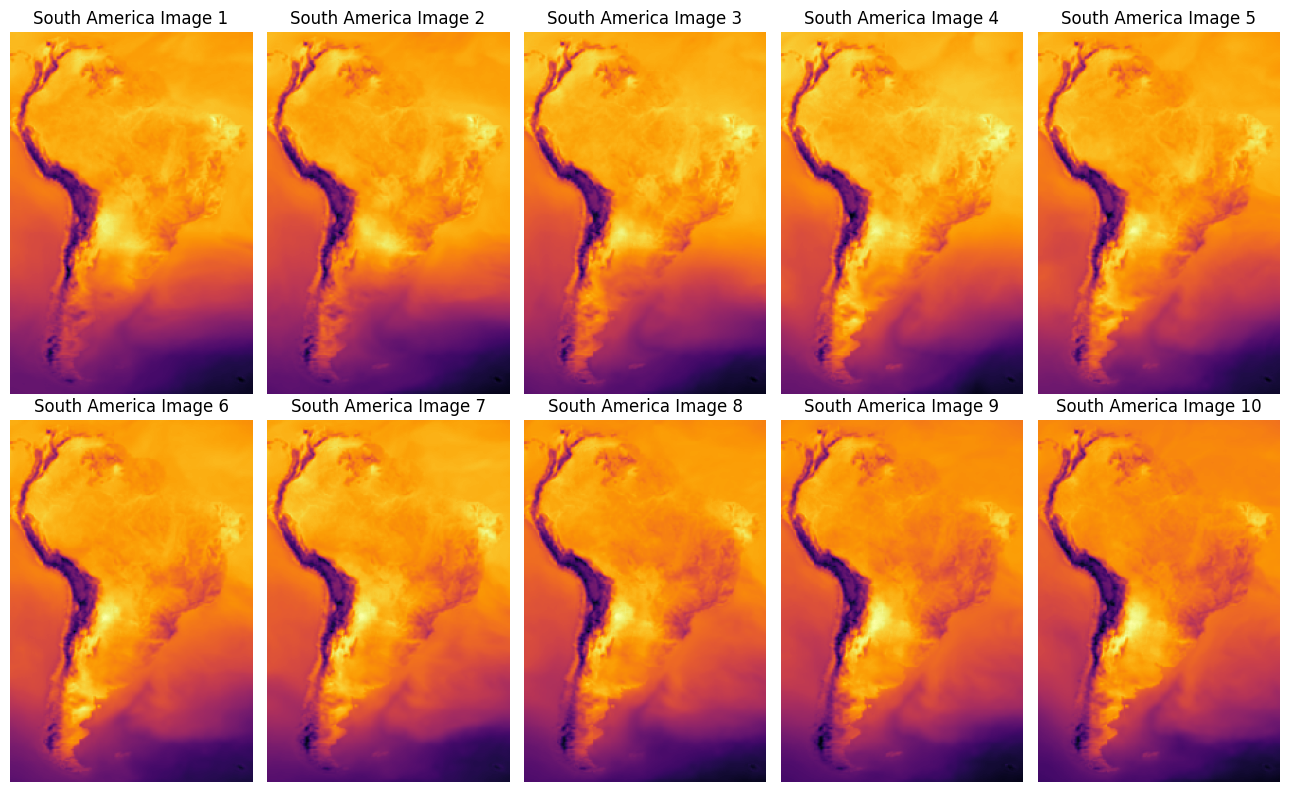

In [ ]:
download_images_for_region(south_america, "South America")

## **Load Time-Series**

In [ ]:
def get_full_history_temperature(region, start_date='1979-01-01', end_date='2024-12-31'):
    def reduce_region(image):
        mean_dict = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=30000,
            bestEffort=True
        )
        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'mean_temp': mean_dict.get('mean_2m_air_temperature')
        })

    start_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()

    all_features = []
    for year in range(start_dt.year, end_dt.year + 1):
        chunk_start = max(start_dt, datetime.date(year, 1, 1))
        chunk_end = min(end_dt, datetime.date(year, 12, 31))
        if chunk_start > chunk_end:
            continue

        collection = (ee.ImageCollection('ECMWF/ERA5/DAILY')
                      .select('mean_2m_air_temperature')
                      .filterDate(chunk_start.strftime('%Y-%m-%d'), chunk_end.strftime('%Y-%m-%d'))
                      .map(reduce_region))

        features = collection.getInfo()['features']
        all_features.extend(features)

    if not all_features:
        return pd.DataFrame(columns=['date', 'temperature_C'])

    dates = [f['properties']['date'] for f in all_features if f['properties']['mean_temp'] is not None]
    temps_kelvin = [f['properties']['mean_temp'] for f in all_features if f['properties']['mean_temp'] is not None]
    temps_celsius = [t - 273.15 for t in temps_kelvin]

    df = pd.DataFrame({
        'date': pd.to_datetime(dates),
        'temperature_C': temps_celsius
    }).set_index('date').sort_index()

    return df

In [ ]:
df_africa = get_full_history_temperature(africa)
df_africa

temperature_C
date                     
1979-01-02      20.068184
1979-01-03      19.625975
1979-01-04      19.379472
1979-01-05      19.597132
1979-01-06      19.948507
...                   ...
2020-07-05      24.464630
2020-07-06      24.381034
2020-07-07      24.498312
2020-07-08      24.446205
2020-07-09      24.492022

[15124 rows x 1 columns]

In [ ]:
df_sa = get_full_history_temperature(south_america)
df_sa

temperature_C
date                     
1979-01-02      19.632136
1979-01-03      19.664547
1979-01-04      19.669025
1979-01-05      19.715172
1979-01-06      19.715789
...                   ...
2020-07-05      16.470812
2020-07-06      15.990616
2020-07-07      15.866897
2020-07-08      16.017935
2020-07-09      16.035392

[15124 rows x 1 columns]

In [ ]:
# more testing (a fully unseen continent)
df_asia = get_full_history_temperature(asia)
df_europe = get_full_history_temperature(europe)

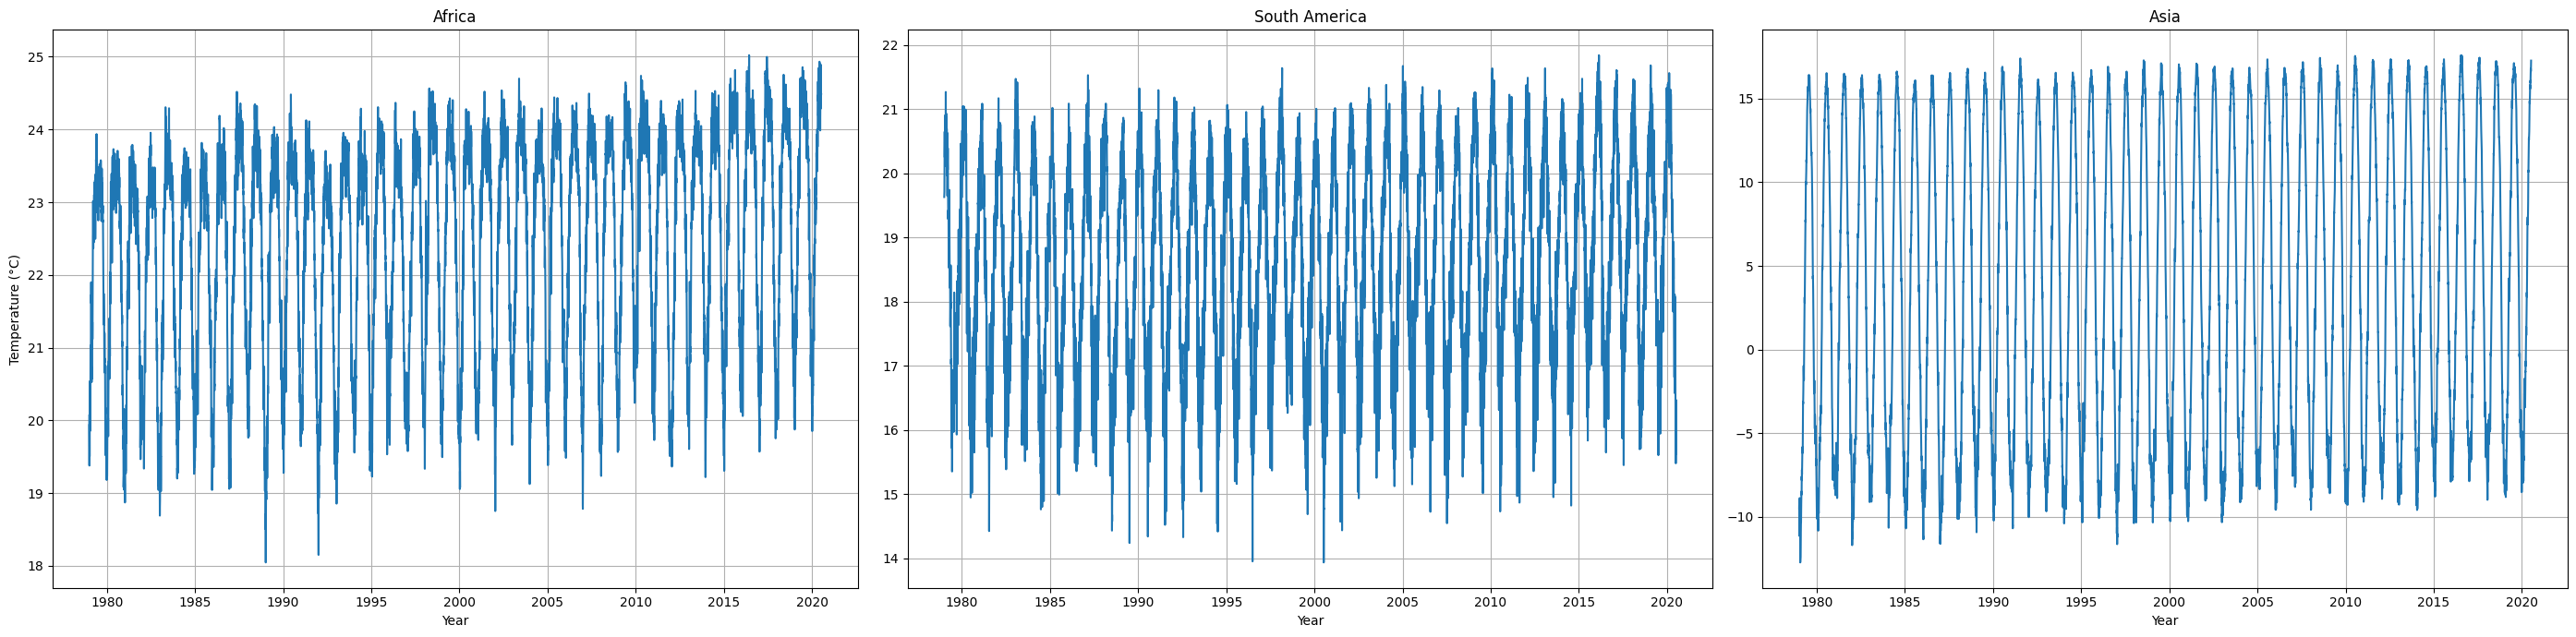

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(28, 7))

axs[0].plot(df_africa.index, df_africa.temperature_C, linestyle='-')
axs[0].set_title('Africa')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Temperature (°C)')

axs[1].plot(df_sa.index, df_sa.temperature_C, linestyle='-')
axs[1].set_title('South America')
axs[1].set_xlabel('Year')

axs[2].plot(df_asia.index, df_asia.temperature_C, linestyle='-')
axs[2].set_title('Asia')
axs[2].set_xlabel('Year')

for ax in axs:
    ax.grid(True)

plt.tight_layout()

In [ ]:
s = df_africa.shape[0] * 80 // 100  # 80% split (12099 row)
merged_df = pd.concat([df_europe[:s], df_asia[:s], df_africa[:s], df_europe[s:] ,df_asia[s:], df_africa[s:]])
merged_df

temperature_C
date                     
1979-01-02     -10.718466
1979-01-03      -9.679480
1979-01-04      -9.342498
1979-01-05      -8.362026
1979-01-06      -7.996587
...                   ...
2020-07-05      24.464630
2020-07-06      24.381034
2020-07-07      24.498312
2020-07-08      24.446205
2020-07-09      24.492022

[45372 rows x 1 columns]

## **Continue Preprocessing**
- normalization using MinMaxScaler
- creating sequences
- finally, splitting the data into training and testing sets

In [ ]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(merged_df)

# sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 100
X, y = create_sequences(scaled_values, seq_length)

X = X.reshape(X.shape[:-1])
X.shape, y.shape

((45272, 100), (45272, 1))

In [ ]:
# south america
sa_values = scaler.transform(df_sa)
X_sa, y_sa = create_sequences(sa_values, seq_length)
X_sa = X_sa.reshape(X_sa.shape[:-1])
X_sa.shape

(15024, 100)

In [ ]:
s *= 3
X_train, X_test = X[:s], X[s:]
y_train, y_test = y[:s], y[s:]

#**2. Modeling**

## **First Model : TCN**

In [ ]:
def build_tcn(input_shape, filters=160, kernel_size=5, dropout=0.2):
    inputs = Input(shape=input_shape)
    x = inputs
    for rate in [1, 2, 4, 8]:
        shortcut = x
        x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=rate)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(dropout)(x)
        shortcut = Conv1D(filters, 1, padding='same')(shortcut) if shortcut.shape[-1] != x.shape[-1] else shortcut
        x = Add()([shortcut, x]) # residual
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(Dense(64, activation='relu')(x))
    return Model(inputs, outputs)

TCN = build_tcn((seq_length, 1))
TCN.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_tcn = TCN.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[EarlyStopping(patience=8, restore_best_weights=True)])


Epoch 1/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.2270 - mae: 0.2921 - val_loss: 0.0041 - val_mae: 0.0508
Epoch 2/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 0.0134 - mae: 0.0911 - val_loss: 0.0039 - val_mae: 0.0459
Epoch 3/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0073 - mae: 0.0671 - val_loss: 0.0037 - val_mae: 0.0475
Epoch 4/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0059 - mae: 0.0598 - val_loss: 0.0021 - val_mae: 0.0174
Epoch 5/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0046 - mae: 0.0528 - val_loss: 0.0026 - val_mae: 0.0210
Epoch 6/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0038 - mae: 0.0475 - val_loss: 0.0019 - val_mae: 0.0196
Epoch 7/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0026 - mae: 0.0395 - val_loss: 0.0085 - val_mae: 0.0850
Epoch 8/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0022 - mae: 0.0361 - val_loss: 0.0028 - val_mae: 0.0406
Epoch 9/50
1021/1021 ━━━━━━━━━━━━━━

In [ ]:
# Evaluating
from sklearn.metrics import mean_squared_error as mse
mse(TCN.predict(X_test), y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


0.0001976253466143967

1135/1135 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


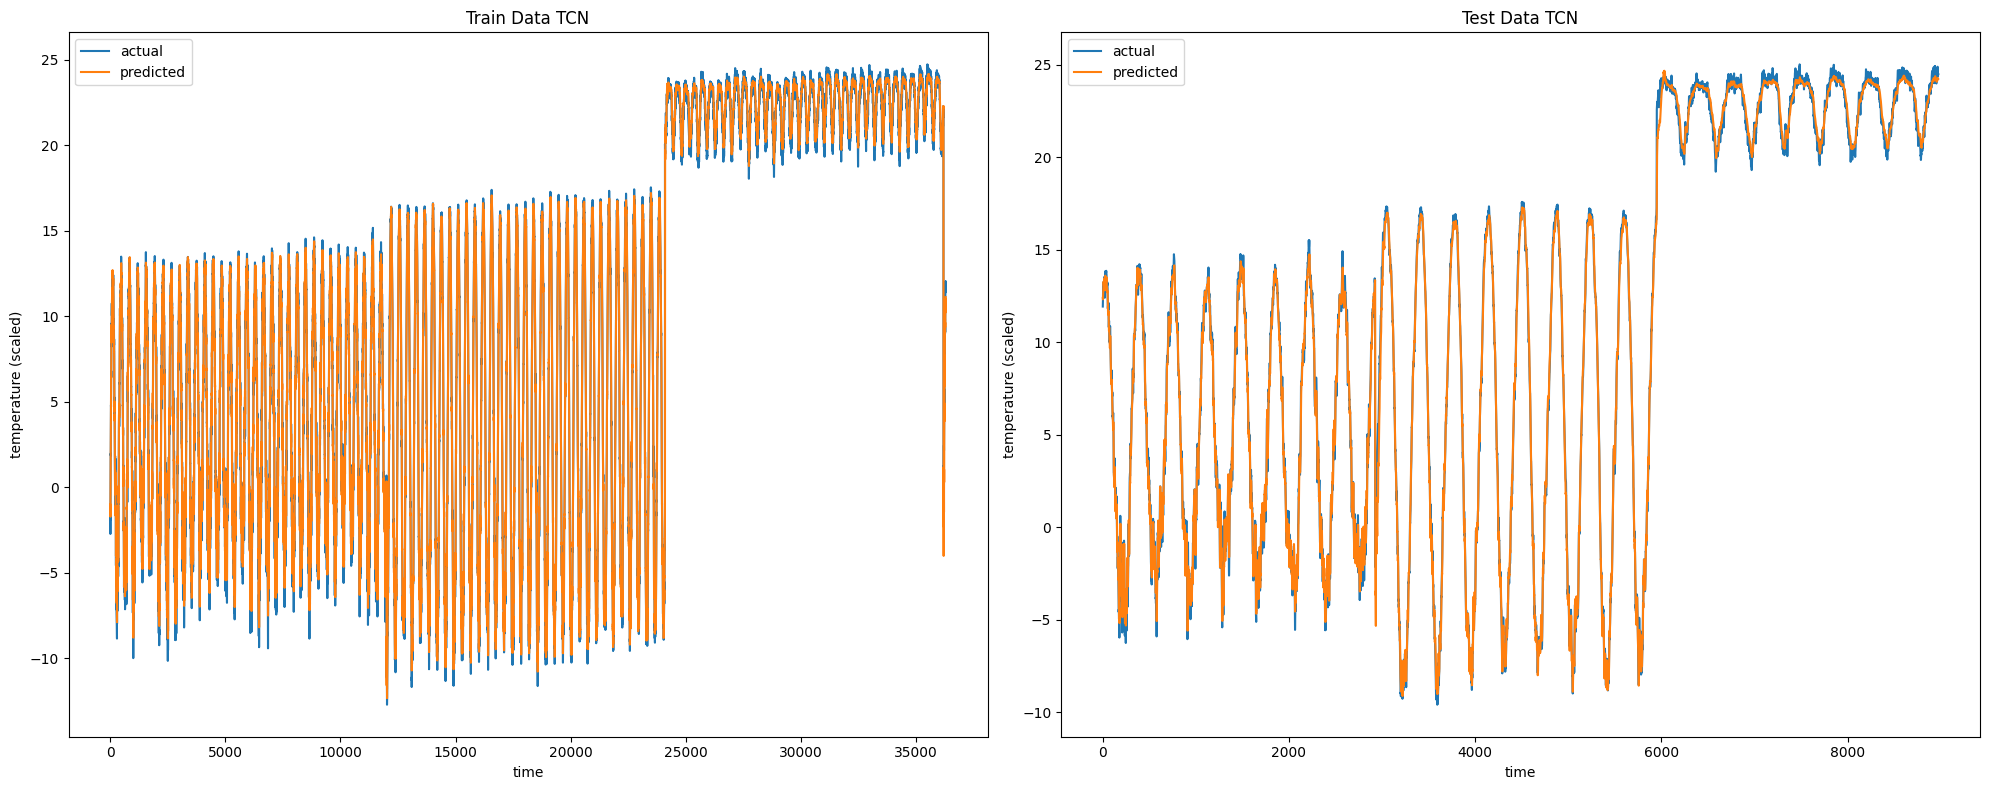

In [ ]:
def our_plot(model, model_name=''):
    y_pred_train = scaler.inverse_transform(model.predict(X_train))
    y_pred_test = scaler.inverse_transform(model.predict(X_test))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.plot(scaler.inverse_transform(y_train), label='actual')
    ax1.plot(y_pred_train, label='predicted')
    ax1.set_title(f'Train Data {model_name}')

    ax2.plot(scaler.inverse_transform(y_test), label='actual')
    ax2.plot(y_pred_test, label='predicted')
    ax2.set_title(f'Test Data {model_name}')

    for ax in [ax1, ax2]:
        ax.set_xlabel('time')
        ax.set_ylabel('temperature (scaled)')
        ax.legend()

    plt.tight_layout()

our_plot(TCN, 'TCN')

In [ ]:
# A fully unseen continent
mse(TCN.predict(X_sa), y_sa)

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


0.00027950915145253356

470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


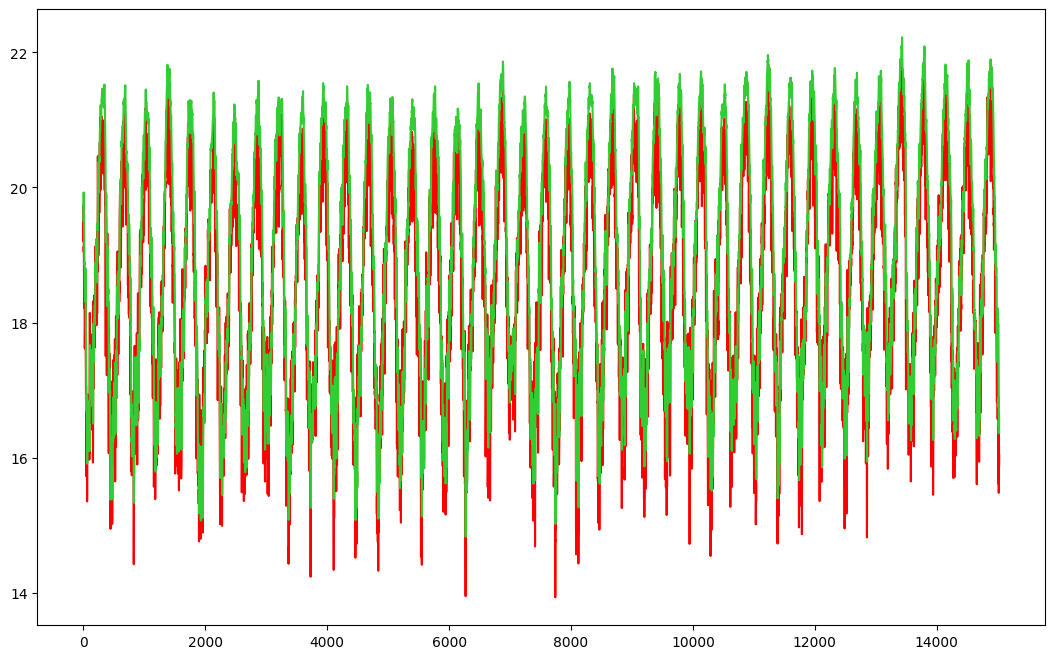

In [ ]:
plt.figure(figsize=(13, 8))
plt.plot(scaler.inverse_transform(y_sa), label='Actual', color="red")
plt.plot(scaler.inverse_transform(TCN.predict(X_sa)), label='Predicted', color="limegreen")

## **Seconod Model : RNN**

In [ ]:
from tensorflow.keras.layers import SimpleRNN

rnn_input = Input(shape=(seq_length, 1))
rnn = SimpleRNN(64, activation='relu')(rnn_input)
rnn_out = Dense(1)(rnn)

RNN = Model(rnn_input, rnn_out)
RNN.compile(optimizer='adam', loss='mse')

history_rnn = RNN.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0277 - val_loss: 1.7288e-04
Epoch 2/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 1.8420e-04 - val_loss: 1.4136e-04
Epoch 3/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 9.8472e-05 - val_loss: 1.0743e-04
Epoch 4/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 6.8492e-05 - val_loss: 1.6748e-04
Epoch 5/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 6.6754e-05 - val_loss: 1.2842e-04
Epoch 6/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 6.2747e-05 - val_loss: 1.3837e-04
Epoch 7/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 6.3959e-05 - val_loss: 1.4154e-04
Epoch 8/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 6.9329e-05 - val_loss: 1.4355e-04


In [ ]:
# mse of rnn
mse(RNN.predict(X_test), y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


6.946776719778506e-05

1135/1135 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


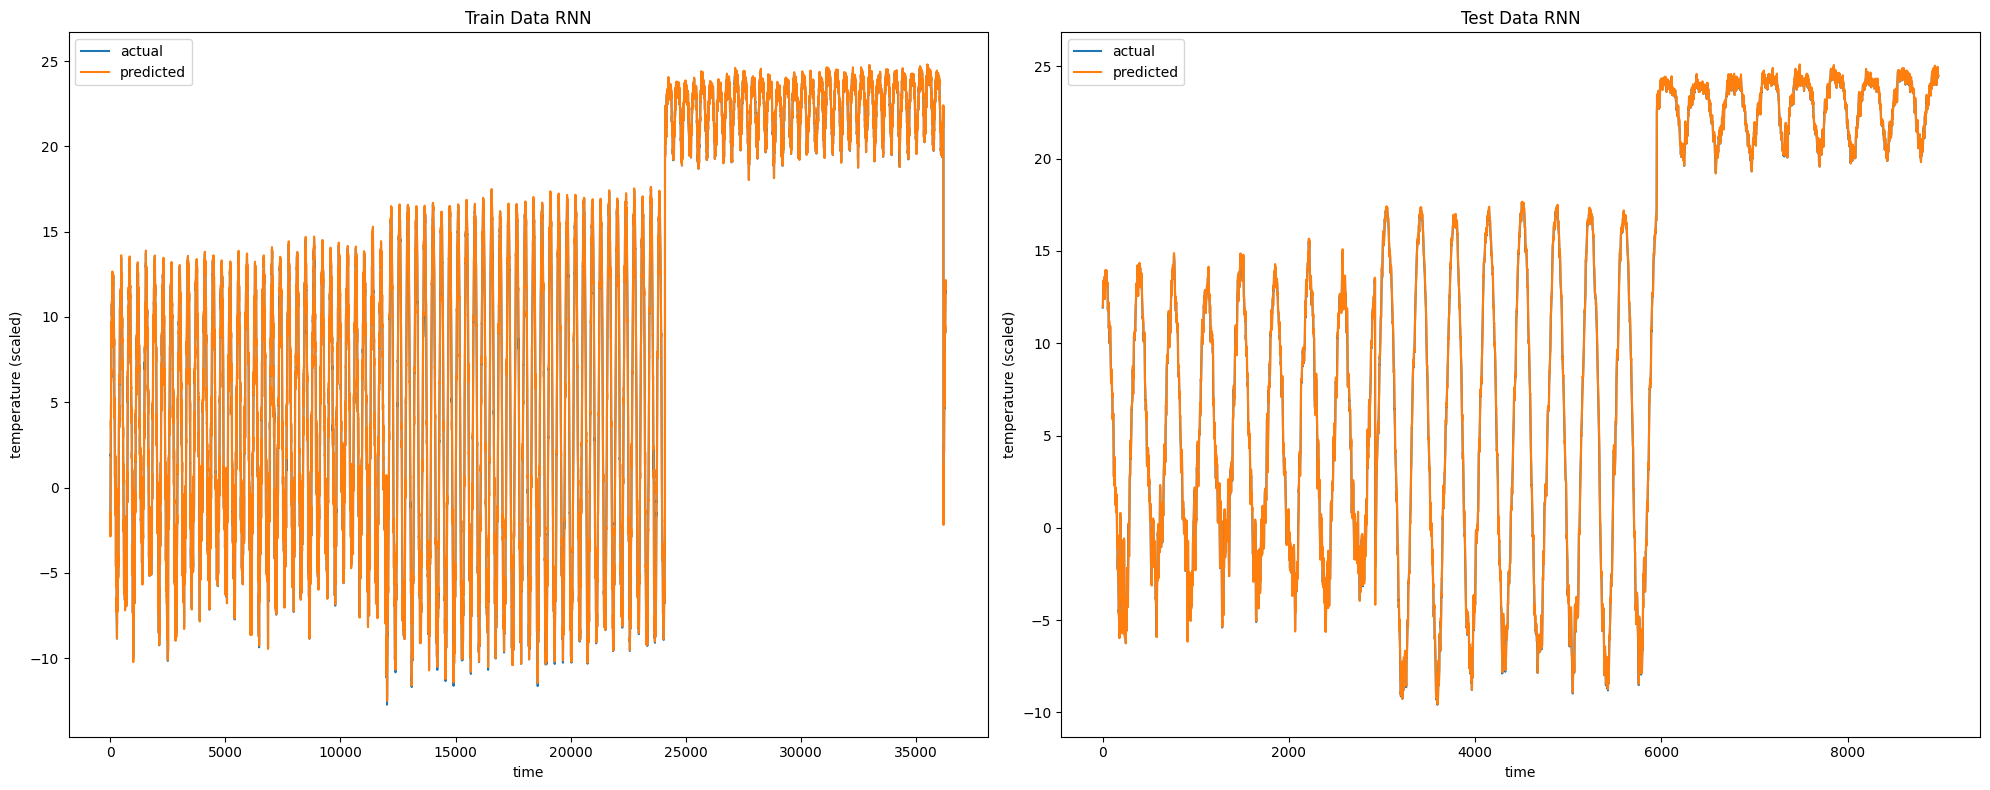

In [ ]:
our_plot(RNN, "RNN")

In [ ]:
mse(RNN.predict(X_sa), y_sa)

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


4.744575717213495e-05

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


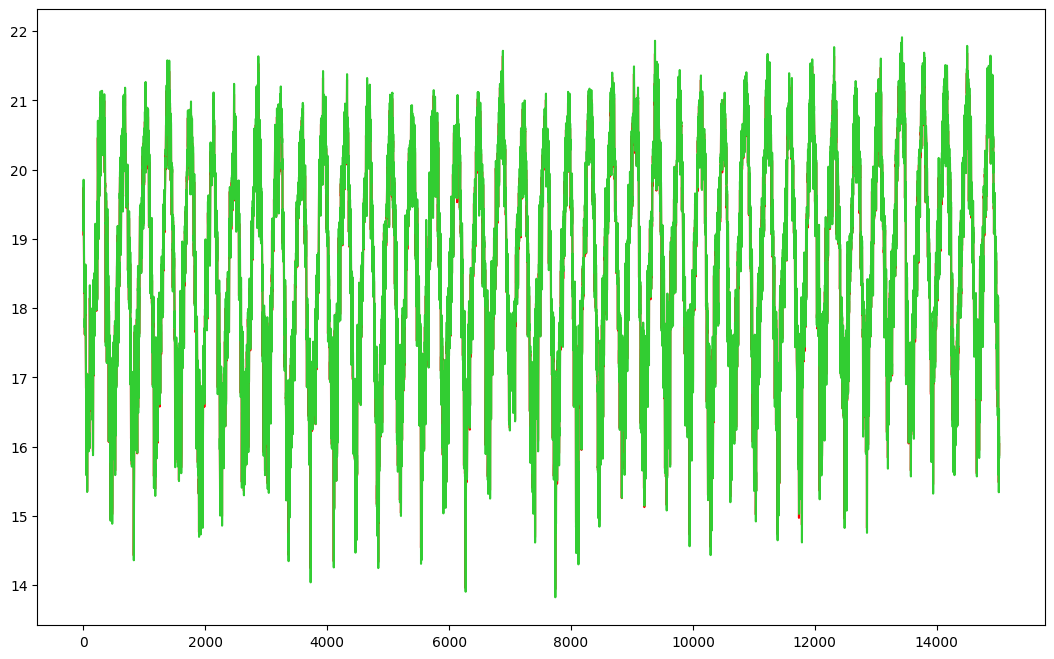

In [ ]:
plt.figure(figsize=(13, 8))
plt.plot(scaler.inverse_transform(y_sa), label='Actual', color="red")
plt.plot(scaler.inverse_transform(RNN.predict(X_sa)), label='Predicted', color="limegreen")

## **Third Model : GRU**

In [ ]:
from keras.layers import GRU

gru_input = Input(shape=(seq_length, 1))
gru = GRU(64, activation='relu')(gru_input)
gru_output = Dense(1)(gru)
GRU = Model(inputs=gru_input, outputs=gru_output)

GRU.compile(optimizer='adam', loss='mse')

GRU.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_gru = GRU.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=8, restore_best_weights=True)]
)

Epoch 1/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0541 - val_loss: 1.3723e-04
Epoch 2/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 1.3727e-04 - val_loss: 1.1506e-04
Epoch 3/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.0764e-04 - val_loss: 1.4890e-04
Epoch 4/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 8.7025e-05 - val_loss: 1.0676e-04
Epoch 5/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 7.5890e-05 - val_loss: 1.0953e-04
Epoch 6/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 6.9196e-05 - val_loss: 1.1375e-04
Epoch 7/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 6.3970e-05 - val_loss: 1.5762e-04
Epoch 8/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 5.9955e-05 - val_loss: 1.5778e-04
Epoch 9/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 6.3426e-05 - val_loss: 1.3009e-04
Epoch 10/50
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 6.7068e-05 - val_loss: 1.3995e-04
Epoch 11/50
1021/1021 ━

In [ ]:
# Evaluating
mse(GRU.predict(X_test), y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


7.0937016289544e-05

1135/1135 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


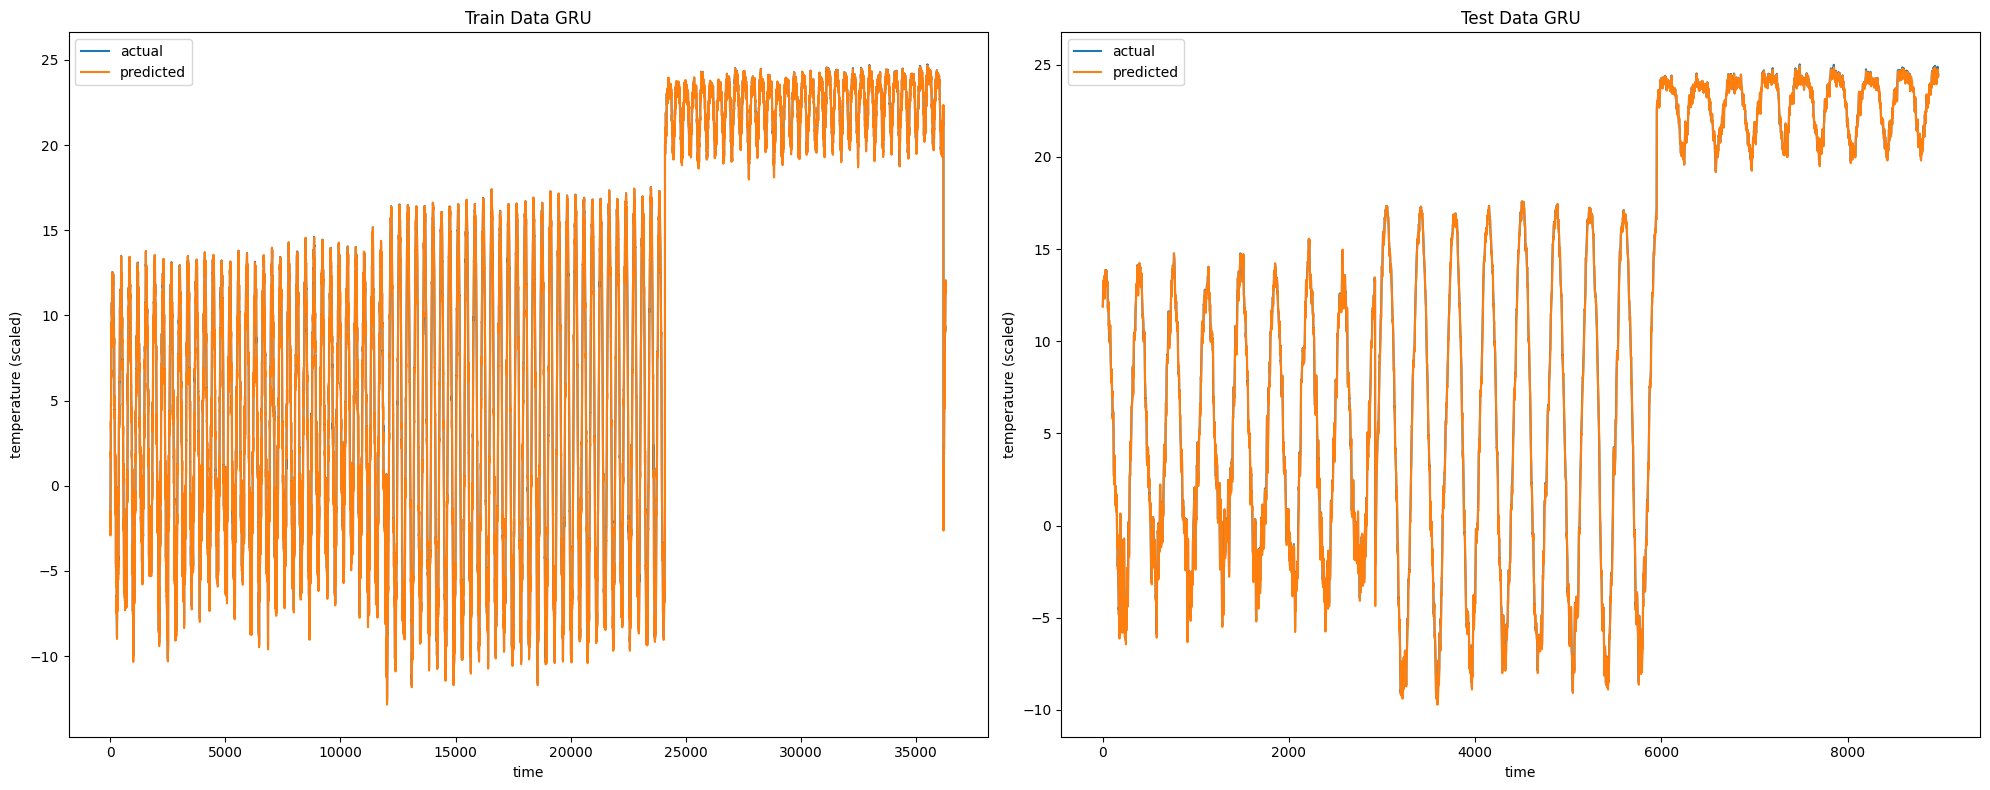

In [ ]:
our_plot(GRU, "GRU")

In [ ]:
# A fully unseen continent
mse(GRU.predict(X_sa), y_sa)

470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


4.483896484143067e-05

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


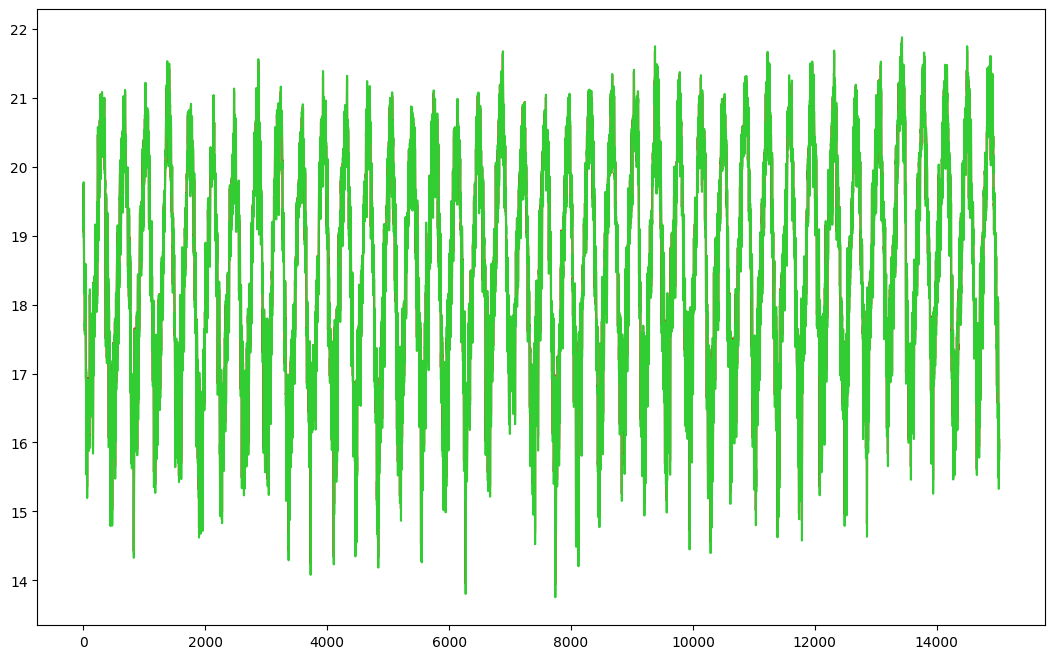

In [ ]:
plt.figure(figsize=(13, 8))
plt.plot(scaler.inverse_transform(y_sa), label='Actual', color="red")
plt.plot(scaler.inverse_transform(GRU.predict(X_sa)), label='Predicted', color="limegreen")

# **Comparing Results**

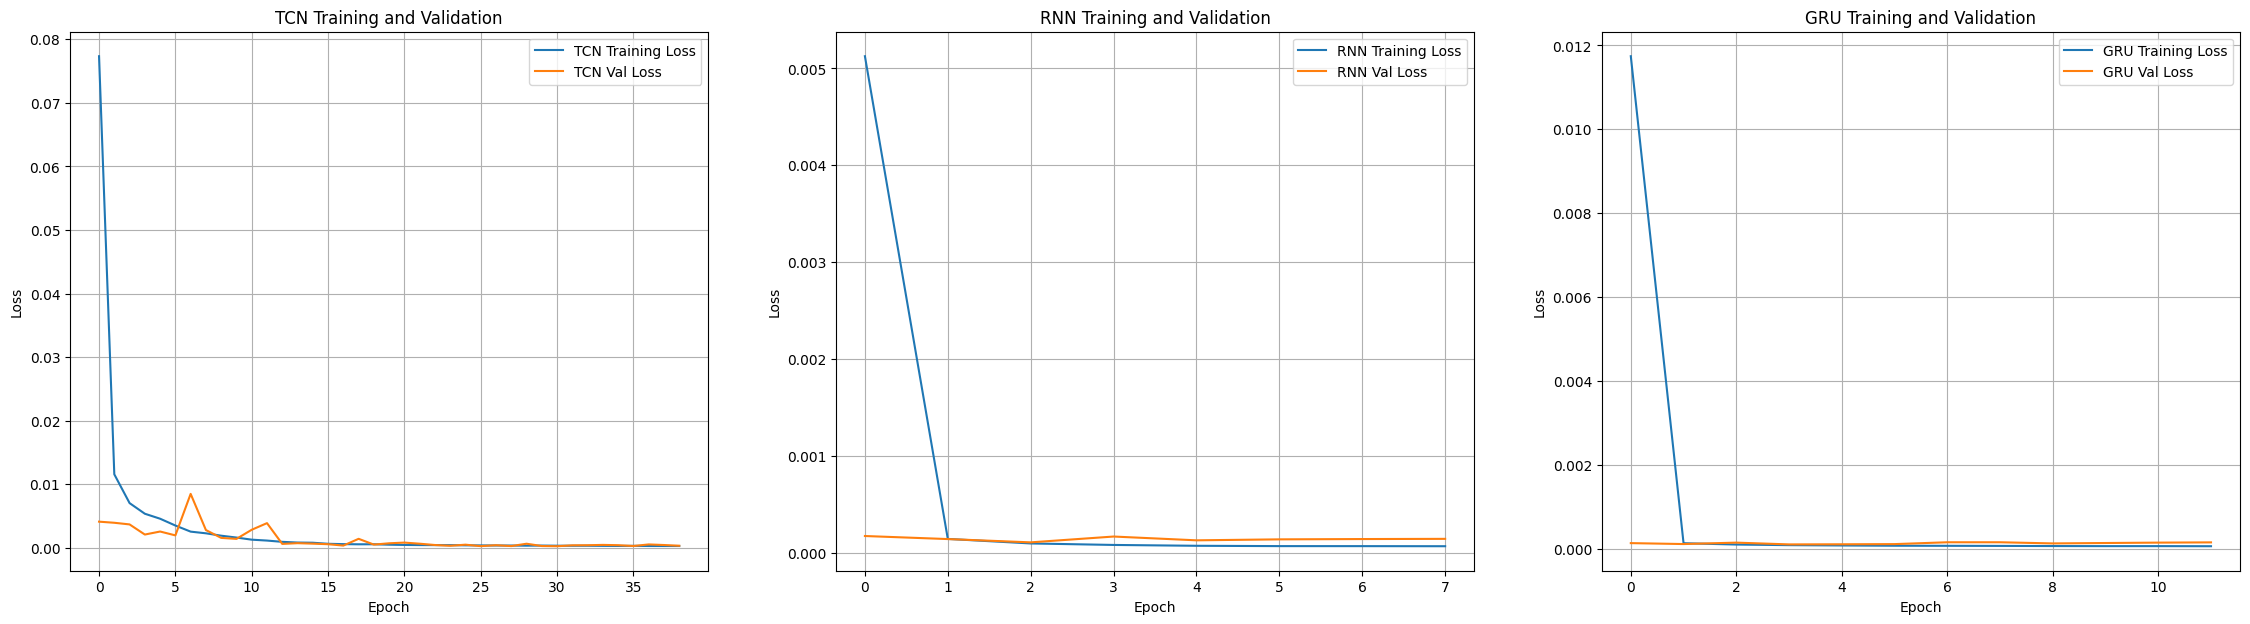

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 7))

ax1.plot(history_tcn.history['loss'], label='TCN Training Loss')
ax1.plot(history_tcn.history['val_loss'], label='TCN Val Loss')

ax2.plot(history_rnn.history['loss'], label='RNN Training Loss')
ax2.plot(history_rnn.history['val_loss'], label='RNN Val Loss')

ax3.plot(history_gru.history['loss'], label='GRU Training Loss')
ax3.plot(history_gru.history['val_loss'], label='GRU Val Loss')

ax1.set_title('TCN Training and Validation')
ax2.set_title('RNN Training and Validation')
ax3.set_title("GRU Training and Validation")

for ax in [ax1, ax2, ax3]:
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend()
  ax.grid(True)

In [ ]:
# Predict and evaluate the 3 models together by calc. Mean Squared Error
from sklearn.metrics import mean_squared_error as mse

predictions_tcn = TCN.predict(X_test)
predictions_rnn = RNN.predict(X_test)
predictions_gru = GRU.predict(X_test)

mse_tcn = mse(y_test, predictions_tcn)
mse_rnn = mse(y_test, predictions_rnn)
mse_gru = mse(y_test, predictions_gru)

print(f"TCN MSE: {mse_tcn}")
print(f"RNN MSE: {mse_rnn}")
print(f"GRU MSE: {mse_gru}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
TCN MSE: 0.0001976253466143967
RNN MSE: 6.946776719778506e-05
GRU MSE: 7.0937016289544e-05
